# Implement two hidden layers neural network classifier from scratch in JAX
   * Two hidden layers here means (input - hidden1 - hidden2 - output).
   * You must not use flax, optax, or any other library for this task.
   * Use MNIST dataset with 80:20 train:test split.
   * Manually optimize the number of neurons in hidden layers.
   * Use gradient descent from scratch to optimize your network. You should use the Pytree concept of JAX to do this elegantly.
   * Plot loss v/s iterations curve with matplotlib.
   * Evaluate the model on test data with various classification metrics and briefly discuss their implications

In [73]:
# imports
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

## MLP training on MNIST

In [89]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):
    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)
    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append(
            [
                scale * jax.random.normal(weight_key, shape=(out_width, in_width)),
                scale * jax.random.normal(bias_key, shape=(out_width,)),
            ]
        )
    return params

key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([28**2, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [76]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)
    w_last, b_last = params[-1]

    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log(exp(o1)/sum(...))
    # kind of softmax activation function
    return logits - logsumexp(logits)

# TESTS

# test single example
# dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
# print(dummy_img_flat.shape)

# Batch testing
# prediction = MLP_predict(MLP_params, dummy_img_flat)
# print(prediction.shape)

batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

# small test
dummy_img_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = batched_MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

(16, 784)
(16, 10)


In [77]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))
    labels = np.array(transposed_data[1])
    imgs = np.array(transposed_data[0])
    return imgs, labels

batch_size = 128

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
#
# print(type(train_dataset))
# print(type(train_dataset[0]))

test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimizing the code: load the full dataset into the memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
# print(train_images.shape, type(train_images))
train_labels = jnp.array(train_dataset.targets)
# print(train_labels.shape, type(train_labels))

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_labels = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


In [79]:
epochs = 10

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)
    return -jnp.mean(predictions * gt_lbls)


def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)
    return loss, jax.tree_multimap(lambda p, g:p - lr*g, params, grads)

# update_jit = jit(update)
losses = {}
# Create an MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)
for epoch in range(epochs):
    for cnt, (imgs, lbls) in enumerate(train_loader):
        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        loss, MLP_params, = update(MLP_params, imgs, gt_labels)
        if cnt % 50 == 0:
            # print(gt_labels.shape)
            print(loss)
    print('Epoch {}: training accuracy = {} testing accuracy = {}'.format(epoch, accuracy(MLP_params, train_images, train_labels), accuracy(MLP_params, test_images, test_labels)))
    losses[epoch] = loss

0.23599091
0.100969754
0.06753465
0.0423462
0.054134
0.046558425
0.039340775
0.033970423
0.030881992
0.02938798
Epoch 0: training accuracy = 0.9129166603088379 testing accuracy = 0.9151999950408936
0.03182727
0.018186614
0.033074494
0.025276436
0.030308291
0.024417734
0.028306056
0.021294132
0.025491342
0.02633152
Epoch 1: training accuracy = 0.934249997138977 testing accuracy = 0.9330999851226807
0.02062715
0.023997147
0.028885826
0.028886223
0.025454521
0.020345856
0.01753876
0.016771747
0.021413742
0.026423544
Epoch 2: training accuracy = 0.9470000267028809 testing accuracy = 0.9447000026702881
0.011180607
0.011329056
0.015772616
0.018831668
0.019619925
0.022133356
0.013968283
0.015674116
0.027574701
0.015703341
Epoch 3: training accuracy = 0.954716682434082 testing accuracy = 0.950499951839447
0.018853394
0.0122182695
0.022891356
0.009240834
0.0060692127
0.019840892
0.01610983
0.018976144
0.021101698
0.02148499
Epoch 4: training accuracy = 0.9585333466529846 testing accuracy = 0.95

(28, 28)
Prediction: 7


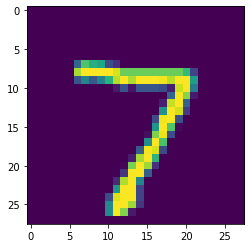

7


In [81]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

print('Prediction: {}'.format(jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))))

plt.imshow(img); plt.show()
print(gt_lbl)

## Visualizations

(512, 784)
(28, 28)


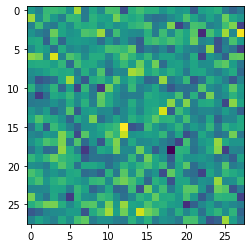

In [82]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[0,: ].reshape(mnist_img_size)
print(w_single.shape)

plt.imshow(w_single); plt.show()

### Analyzing dead neurons

(128, 256)


/home/kunalkumarsahoo/anaconda3/envs/SRIP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kunalkumarsahoo/anaconda3/envs/SRIP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


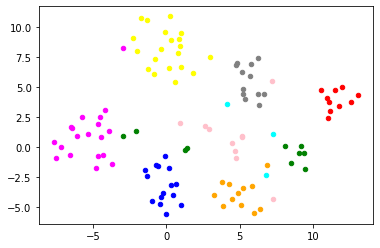

In [83]:
from sklearn.manifold import TSNE

def fetch_activations(params, x):
    hidden_layers = params[:-1]
    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation)+b)
    return activation

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))
imgs, lbls = next(iter(test_loader))
batch_activations = batched_fetch_activations(MLP_params, imgs)
print(batch_activations.shape)

t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(batch_activations)

color_label = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'yellow', 5: 'pink', 6: 'gray', 7: 'magenta', 8: 'cyan', 9: 'white'}
for class_id in range(10):
    plt.scatter(t_sne_embeddings[lbls == class_id, 0], t_sne_embeddings[lbls == class_id, 1], s=20, color=color_label[class_id])
plt.show()

In [90]:
def fetch_activations2(params, x):
    hidden_layers = params[:-1]
    collector = []
    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation)+b)
        collector.append(activation)
    return collector

batched_fetch_activations2 = vmap(fetch_activations2, in_axes=(None, 0))
imgs, lbls = next(iter(test_loader))

MLP_params2 = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

batch_activations = batched_fetch_activations2(MLP_params2, imgs)
print(batch_activations[1].shape)

dead_neurons = [np.ones(act.shape[1:]) for act in batch_activations]

for layers_id, activations in enumerate(batch_activations):
    dead_neurons[layers_id] = np.logical_and(dead_neurons[layers_id], (activations == 0).all(axis=0))

for layers in dead_neurons:
    print(np.sum(layers))

(128, 256)
0
7


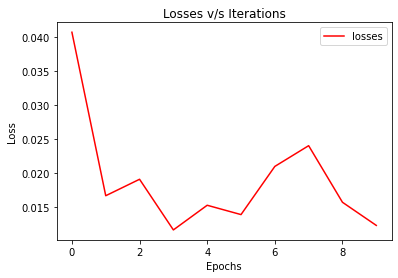

In [87]:
x_values, y_values = [], []
x_values = list(losses.keys())
for key in x_values:
    y_values.append(losses[key])

plt.plot(x_values, y_values, 'r', label='losses')
plt.title('Losses v/s Iterations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()